# Continue Fine Tuning MediLlama-3.2

In [1]:
%%capture
%pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
%pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
%pip install --no-deps unsloth

In [2]:
# import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wb_token = user_secrets.get_secret("wandb")

# wandb.login(key=wb_token)
# run = wandb.init(
#     project='Clinical-Llama-3.2-3B', 
#     job_type="training", 
#     anonymous="allow"
# )

In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")
login(hf_token)

## Load Lora Adaptors from Hub (Guide in Phase 1)

In [1]:
!git clone https://huggingface.co/InferenceLab/MediLlama-3.2-LoraAdaptors

Cloning into 'MediLlama-3.2-LoraAdaptors'...
Updating files:  71% (5/7)
Updating files:  85% (6/7)
Updating files: 100% (7/7)
Updating files: 100% (7/7), done.
Filtering content: 100% (2/2)
Filtering content: 100% (2/2), 109.21 MiB | 20.16 MiB/s, done.


In [5]:
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import train_on_responses_only

def load_model_and_tokenizer(max_seq_length=2048, dtype=None, load_in_4bit=True):
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name="MediLlama-3.2-LoraAdaptors",  ## Give path to your Lora Adaptor
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
    )
    return model, tokenizer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-05-18 04:47:06.149042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747543626.336974      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747543626.390208      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


## Train Model Parameters

In [6]:
from transformers import EarlyStoppingCallback, TextStreamer, TrainingArguments

def create_trainer(model, tokenizer, train_dataset,eval_dataset, training_args):
    callbacks = [
        EarlyStoppingCallback(training_args["early_stopping_patience"]),
    ]

    args = TrainingArguments(
        per_device_train_batch_size=training_args["per_device_train_batch_size"],
        per_device_eval_batch_size=training_args["per_device_eval_batch_size"],
        gradient_accumulation_steps=training_args["gradient_accumulation_steps"],
        logging_steps=training_args["logging_steps"],
        output_dir=training_args["output_dir"],
        save_strategy = "steps",
        save_steps=training_args["save_steps"],     ## Fine tuning from last checkpoint
        warmup_steps=training_args["warmup_steps"],
        num_train_epochs=training_args["num_train_epochs"],
        learning_rate=training_args["learning_rate"],
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        weight_decay=training_args["weight_decay"],
        lr_scheduler_type=training_args["lr_scheduler_type"],
        seed=training_args["seed"],
        report_to=training_args["report_to"],            ## wandb if want metrics
        optim=training_args["optim"],

        # ✅ Fields related to Validation loss:
        eval_strategy=training_args["eval_strategy"],
        eval_steps=training_args["eval_steps"],
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",  # Or "eval_accuracy", depending on your metric
        greater_is_better=False,
    )

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset= train_dataset, 
        eval_dataset= eval_dataset,
        dataset_text_field=training_args["dataset_text_field"],
        max_seq_length=training_args["max_seq_length"],
        data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
        dataset_num_proc=training_args["dataset_num_proc"],
        packing=training_args["packing"],
        args=args,
        callbacks=callbacks
    )

    trainer = train_on_responses_only(
        trainer,
        instruction_part=training_args["instruction_part"],
        response_part=training_args["response_part"],
    )
    return trainer


In [7]:
def train_model(trainer):
    return trainer.train()

## Run Model

In [8]:
def run_model(model, tokenizer, instruction, query):
    FastLanguageModel.for_inference(model)
    messages = [
        {"role": "system", "content": instruction},
        {"role": "user", "content": query},
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=1500, num_return_sequences=1)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text

## Preprocessing Data

In [9]:
def visualize_data(df):
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nData Types and Non-Null Info:")
    print(df.info())
    print("-" * 50)

    # Null value check
    print("Null values:\n", df.isna().sum())
    print("-" * 50)

    # Duplicate rows
    print("Duplicate rows:", df.duplicated().sum())
    print("-" * 50)


In [10]:
from unsloth.chat_templates import get_chat_template
from datasets import Dataset

instruction = """You are a helpful and knowledgeable medical expert."""

def format_chat_template(row):

    row_json = [{"role": "system", "content": instruction },
               {"role": "user", "content": row['input']},
               {"role": "assistant", "content": row['output']}]
    
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

## Load Dataset

In [11]:
from datasets import load_dataset
dataset = load_dataset("InferenceLab/healthcare_terms_glossary")
dataset = dataset['train'].select(range(20000))
### split test and train
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
df_train = split_dataset["train"]
df_test = split_dataset["test"]
print(df_train)
print(df_test)

README.md:   0%|          | 0.00/539 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.97M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 16000
})
Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 4000
})


## Train Dataset

In [12]:
df = df_train.to_pandas()
visualize_data(df)
df.head()

Shape: (16000, 3)
Columns: ['input', 'output', 'instruction']

Data Types and Non-Null Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input        16000 non-null  object
 1   output       16000 non-null  object
 2   instruction  16000 non-null  object
dtypes: object(3)
memory usage: 375.1+ KB
None
--------------------------------------------------
Null values:
 input          0
output         0
instruction    0
dtype: int64
--------------------------------------------------
Duplicate rows: 15
--------------------------------------------------


,input,output,instruction
0,"What is biofeedback psychotherapy, and how doe...",Biofeedback psychotherapy is a type of therapy...,Answer this question truthfully
1,Which viral pathogens are most commonly associ...,Coxsackie B and Adenovirus are the viral patho...,Answer this question truthfully
2,What is the treatment for prolactinoma and wha...,Prolactinoma is a type of tumor that affects t...,Answer this question truthfully
3,"What is the pudendal nerve, and how does it re...",The pudendal nerve is a nerve that originates ...,Answer this question truthfully
4,What strain of influenza is targeted by M2 cha...,"M2 channel blockers, including rimantadine and...",Answer this question truthfully


In [13]:
# 1. Load model and tokenizer
model, tokenizer = load_model_and_tokenizer()

==((====))==  Unsloth 2025.5.6: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

Unsloth 2025.5.6 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [14]:
train_dataset = df_train.map(
    format_chat_template,
    num_proc= 4,
)
print(len(train_dataset), train_dataset["text"][0])

Map (num_proc=4):   0%|          | 0/16000 [00:00<?, ? examples/s]

16000 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 18 May 2025

You are a helpful and knowledgeable medical expert.<|eot_id|><|start_header_id|>user<|end_header_id|>

What is biofeedback psychotherapy, and how does it use signals from the body to help patients manage emotional distress?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Biofeedback psychotherapy is a type of therapy that helps patients learn to control their physiological responses to stress and anxiety. It involves using sensors to monitor signals from the body such as heart rate, muscle tension, skin temperature, and blood pressure. These signals serve as indicators of emotional distress, and patients are taught to recognize them and use relaxation techniques to control their physiological reactions. By learning to control these physical responses, patients can reduce symptoms of anxiety and stress, and gain a greater sense of control over their e

## Test Data

In [15]:
test_dataset = df_test.map(
    format_chat_template,
    num_proc= 4,
)
print(len(test_dataset), test_dataset["text"][1])

Map (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

4000 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 18 May 2025

You are a helpful and knowledgeable medical expert.<|eot_id|><|start_header_id|>user<|end_header_id|>

Which arteries in the fetal circulatory system supply deoxygenated blood to the placenta through the umbilical arteries?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The umbilical arteries return deoxygenated blood from the fetal internal iliac arteries to the placenta. The internal iliac arteries are responsible for supplying blood to the pelvic region, including the bladder, rectum, and reproductive organs. During fetal development, the umbilical cord connects the fetus to the placenta, which acts as the primary site of oxygen and nutrient exchange between the maternal and fetal circulatory systems. The umbilical arteries are two of the three blood vessels in the umbilical cord, and they carry deoxygenated blood from the fetal body to the placen

## Set Model and Trainer

In [16]:
# 1. Load model and tokenizer
model, tokenizer = load_model_and_tokenizer()


==((====))==  Unsloth 2025.5.6: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [17]:
# 3. Create trainer
training_args = {
    "per_device_eval_batch_size": 6,  ## test batch size should fit in GPU ## all batches get tested at once
    "per_device_train_batch_size": 6,  ## train batch size should fit in GPU
    "gradient_accumulation_steps": 4,
    "eval_strategy": "steps",
    "eval_steps": 50,
    "early_stopping_patience": 3,
    "logging_steps": 1,
    "save_steps": 50,                  ## total steps = (len(train_dataset)//(per_device_train_batch_size*gradient_accumulation_steps))  
    "warmup_steps": 34,
    "num_train_epochs": 1,
    "learning_rate": 1e-5,
    "weight_decay": 0.01,
    "lr_scheduler_type": "linear",
    "seed": 3407,
    "output_dir": "outputs",
    "report_to": "none",               ## use for wandb etc
    "optim": "adamw_8bit",
    "max_seq_length": 2048,
    "dataset_num_proc": 2,
    "packing": False,
    "dataset_text_field": "text",
    "instruction_part": "<|start_header_id|>user<|end_header_id|>\n\n",
    "response_part": "<|start_header_id|>assistant<|end_header_id|>\n\n",
}

trainer = create_trainer(model, tokenizer, train_dataset, test_dataset, training_args)


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/16000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/4000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/16000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

## Begin Training

In [18]:
# 4. Train model
trainer_stats = train_model(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 16,000 | Num Epochs = 1 | Total steps = 666
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 4 x 1) = 24
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
50,0.893000,0.897122
100,0.823100,0.834464
150,0.741300,0.806310
200,0.765700,0.789024
250,0.847400,0.776591
300,0.691500,0.768130
350,0.768800,0.762145
400,0.856600,0.757777
450,0.745500,0.754711
500,0.760200,0.752456


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


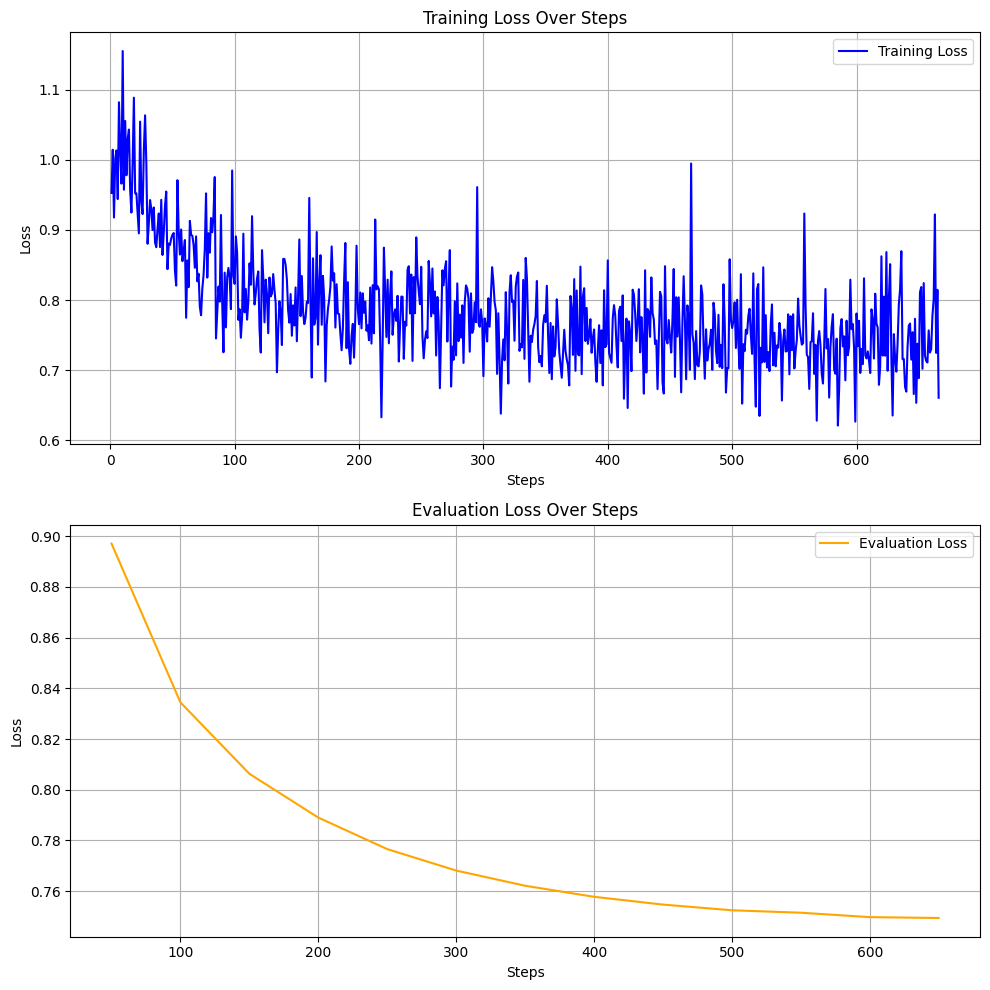

In [19]:
import matplotlib.pyplot as plt

# Collect logs
logs = trainer.state.log_history

# Initialize lists for plotting
train_loss = []
eval_loss = []
eval_steps = []
train_steps = []

# Extract values from logs
for entry in logs:
    if 'loss' in entry and 'step' in entry:
        train_loss.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Training Loss
axs[0].plot(train_steps, train_loss, color='blue', label="Training Loss")
axs[0].set_title("Training Loss Over Steps")
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# Plot Evaluation Loss
axs[1].plot(eval_steps, eval_loss, color='orange', label="Evaluation Loss")
axs[1].set_title("Evaluation Loss Over Steps")
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


## Inference 

In [27]:
instruction = "You are a helpful assistant."
query = "Hi!"
result = run_model(model, tokenizer, instruction, query)
print(result)

system

Cutting Knowledge Date: December 2023
Today Date: 18 May 2025

You are a helpful assistant.user

Hi!assistant

How can I assist you today?


In [34]:
instruction = "You are a helpful assistant."
query = "What medical condition is associated with α1-antitrypsin deficiency, and how does it manifest in the lungs?"
result = run_model(model, tokenizer, instruction, query)
print(result)

system

Cutting Knowledge Date: December 2023
Today Date: 18 May 2025

You are a helpful assistant.user

What medical condition is associated with α1-antitrypsin deficiency, and how does it manifest in the lungs?assistant

α1-antitrypsin deficiency is associated with chronic obstructive pulmonary disease (COPD), which manifests as a progressive decline in lung function.


## Save the Lora Adaptor Locally

In [31]:
model.save_pretrained("MediLlama-3.2-LoraAdaptors")  
tokenizer.save_pretrained("MediLlama-3.2-LoraAdaptors")

('MediLlama-3.2-LoraAdaptors/tokenizer_config.json',
 'MediLlama-3.2-LoraAdaptors/special_tokens_map.json',
 'MediLlama-3.2-LoraAdaptors/tokenizer.json')

## Save Lora Adaptor to Hugging Hub

In [ ]:
model.push_to_hub("your_username/MediLlama-3.2-LoraAdaptors", token = hf_token) # Online saving
tokenizer.push_to_hub("your_username/MediLlama-3.2-LoraAdaptors", token = hf_token) # Online saving

## Merge Lora Adaptor with base model and save to Hub

In [ ]:
# Merge to 16bit
model.save_pretrained_merged("MediLlama-3.2", tokenizer, save_method = "merged_16bit",)
model.push_to_hub_merged("your_username/MediLlama-3.2", tokenizer, save_method = "merged_16bit", token = hf_token)